## Running experiments for May6th meeting

In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [3]:
def runNAgents(function, runs, store=False, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRooms-Goal-9', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [4]:
class DQN():
    def __init__(self, weights_loc, game='FourRooms-Goal-9'):
        config = Config()
        config.game = game
        config.task_fn = lambda: Task(config.game)
        config.eval_env = config.task_fn()
        self.network = VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
        self.network.load_state_dict(torch.load(weights_loc))
    
agents = []
for i in tqdm(range(104)):
    agents.append(DQN('storage/DQN-FourRooms-Goal-'+str(i)+'.weights'))

In [5]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=()) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(0.8, 0.8, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 2e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [9]:
room_centers = [22, 38, 75, 91]
# room_centers = [22, 75, 91]
center_agents = []
for i in room_centers:
    center_agents.append(agents[i])

In [10]:
avdsr = avdsr_feature(game='FourRooms-Goal-9', agents=center_agents, choice=1)

2020-05-18 19:28:46,758 - root - INFO: steps 0, 131072000.00 steps/s
2020-05-18 19:28:47,833 - root - INFO: steps 1000, 931.97 steps/s
2020-05-18 19:28:48,961 - root - INFO: steps 2000, 886.78 steps/s
2020-05-18 19:28:50,004 - root - INFO: steps 3000, 960.03 steps/s
2020-05-18 19:28:51,058 - root - INFO: steps 4000, 949.68 steps/s
2020-05-18 19:28:52,160 - root - INFO: steps 5000, 908.89 steps/s
2020-05-18 19:28:53,267 - root - INFO: steps 6000, 903.93 steps/s
2020-05-18 19:28:54,363 - root - INFO: steps 7000, 913.39 steps/s
2020-05-18 19:28:55,435 - root - INFO: steps 8000, 936.31 steps/s
2020-05-18 19:28:56,563 - root - INFO: steps 9000, 887.26 steps/s
2020-05-18 19:28:57,682 - root - INFO: steps 10000, 894.39 steps/s
2020-05-18 19:28:58,730 - root - INFO: steps 11000, 955.97 steps/s
2020-05-18 19:28:59,824 - root - INFO: steps 12000, 914.72 steps/s
2020-05-18 19:29:00,977 - root - INFO: steps 13000, 867.93 steps/s
2020-05-18 19:29:02,166 - root - INFO: steps 14000, 841.78 steps/s
20

2020-05-18 19:31:34,599 - root - INFO: steps 123000, 535.74 steps/s
2020-05-18 19:31:36,225 - root - INFO: steps 124000, 615.49 steps/s
2020-05-18 19:31:37,884 - root - INFO: steps 125000, 603.38 steps/s
2020-05-18 19:31:39,492 - root - INFO: steps 126000, 622.50 steps/s
2020-05-18 19:31:41,038 - root - INFO: steps 127000, 647.59 steps/s
2020-05-18 19:31:42,400 - root - INFO: steps 128000, 734.62 steps/s
2020-05-18 19:31:43,796 - root - INFO: steps 129000, 717.42 steps/s
2020-05-18 19:31:45,235 - root - INFO: steps 130000, 695.43 steps/s
2020-05-18 19:31:46,594 - root - INFO: steps 131000, 736.83 steps/s
2020-05-18 19:31:48,107 - root - INFO: steps 132000, 661.41 steps/s
2020-05-18 19:31:49,511 - root - INFO: steps 133000, 712.87 steps/s
2020-05-18 19:31:50,839 - root - INFO: steps 134000, 753.58 steps/s
2020-05-18 19:31:52,369 - root - INFO: steps 135000, 654.31 steps/s
2020-05-18 19:31:53,843 - root - INFO: steps 136000, 678.88 steps/s
2020-05-18 19:31:55,333 - root - INFO: steps 137

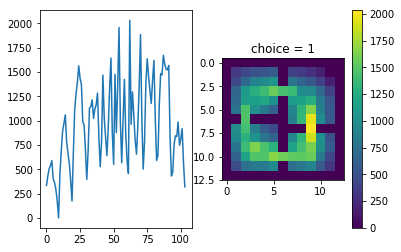

1


In [11]:
state = np.zeros(len(avdsr.replay.data))
for i in range(len(avdsr.replay.data)):
    state[i] = np.argmax(avdsr.replay.data[i][0])
counts = np.zeros(104)
for i in range(len(avdsr.replay.data)):
    counts[int(state[i])] += 1
plt.subplot(121)
plt.plot(counts)
plt.subplot(122)
visualize_vector(counts, title='choice = '+str(avdsr.choice))
print(avdsr.choice)

In [12]:
len(avdsr.actor.agents)

4

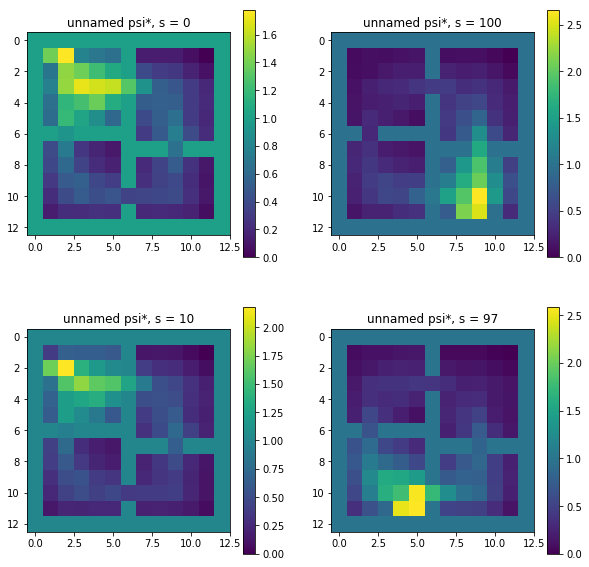

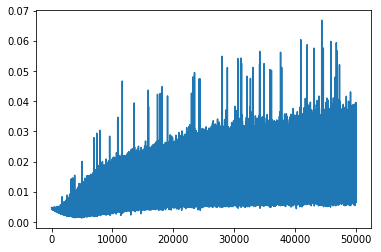

In [13]:
sanity_psi(avdsr)
plt.show()
plt.plot(avdsr.loss_vec)

In [14]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [15]:
# r_dsr_init_dqns_4rooms_c0 = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr) 
r_dsr_init_dqns = runNAgents(dsr_feature_init, runs=1, freeze=2, ref=avdsr) 
r_dsr_init_rand = runNAgents(dsr_feature_init, runs=1, freeze=2, ref=avdsr)
# r_dsr_init_ood_c0 = runNAgents(dsr_feature_init, runs=1, freeze=2, ref=avdsr)
r_dqn_base = runNAgents(dqn_feature, runs=1)

2020-05-18 19:41:21,274 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-05-18 19:41:29,733 - root - INFO: steps 5000, episodic_return_test -140.80(28.60)
2020-05-18 19:41:36,672 - root - INFO: steps 10000, episodic_return_test -180.70(18.31)
2020-05-18 19:41:42,431 - root - INFO: steps 15000, episodic_return_test -24.50(18.53)
2020-05-18 19:41:49,114 - root - INFO: steps 20000, episodic_return_test -7.30(1.33)
2020-05-18 19:41:56,474 - root - INFO: steps 25000, episodic_return_test -11.60(1.14)
2020-05-18 19:42:03,387 - root - INFO: steps 30000, episodic_return_test -10.50(1.12)
2020-05-18 19:42:09,943 - root - INFO: steps 35000, episodic_return_test -11.50(1.35)
2020-05-18 19:42:16,799 - root - INFO: steps 40000, episodic_return_test -10.50(1.84)
2020-05-18 19:42:23,590 - root - INFO: steps 45000, episodic_return_test -12.70(1.10)
2020-05-18 19:42:30,345 - root - INFO: steps 50000, episodic_return_test -7.70(1.33)


2020-05-18 19:42:31,343 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-05-18 19:42:38,781 - root - INFO: steps 5000, episodic_return_test -180.50(18.50)
2020-05-18 19:42:46,929 - root - INFO: steps 10000, episodic_return_test -180.60(18.40)
2020-05-18 19:42:53,853 - root - INFO: steps 15000, episodic_return_test -63.90(28.20)
2020-05-18 19:43:01,137 - root - INFO: steps 20000, episodic_return_test -6.60(1.83)
2020-05-18 19:43:07,633 - root - INFO: steps 25000, episodic_return_test -9.30(1.39)
2020-05-18 19:43:14,960 - root - INFO: steps 30000, episodic_return_test -11.70(1.57)
2020-05-18 19:43:22,593 - root - INFO: steps 35000, episodic_return_test -11.00(1.48)
2020-05-18 19:43:30,202 - root - INFO: steps 40000, episodic_return_test -11.50(1.78)
2020-05-18 19:43:38,192 - root - INFO: steps 45000, episodic_return_test -12.60(1.24)
2020-05-18 19:43:46,064 - root - INFO: steps 50000, episodic_return_test -7.70(1.26)


2020-05-18 19:43:46,937 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-05-18 19:43:54,611 - root - INFO: steps 5000, episodic_return_test -141.60(28.21)
2020-05-18 19:44:01,767 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2020-05-18 19:44:08,857 - root - INFO: steps 15000, episodic_return_test -121.40(30.44)
2020-05-18 19:44:15,338 - root - INFO: steps 20000, episodic_return_test -47.30(24.16)
2020-05-18 19:44:21,853 - root - INFO: steps 25000, episodic_return_test -48.50(23.96)
2020-05-18 19:44:28,114 - root - INFO: steps 30000, episodic_return_test -12.20(1.57)
2020-05-18 19:44:34,514 - root - INFO: steps 35000, episodic_return_test -9.50(1.38)
2020-05-18 19:44:40,359 - root - INFO: steps 40000, episodic_return_test -11.60(1.19)
2020-05-18 19:44:46,017 - root - INFO: steps 45000, episodic_return_test -10.20(1.67)
2020-05-18 19:44:51,965 - root - INFO: steps 50000, episodic_return_test -9.70(1.90)


In [17]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = np.interp(np.arange(clip), t, r)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(convolve(mean,1000), label=k, color=colors[j])
#         plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

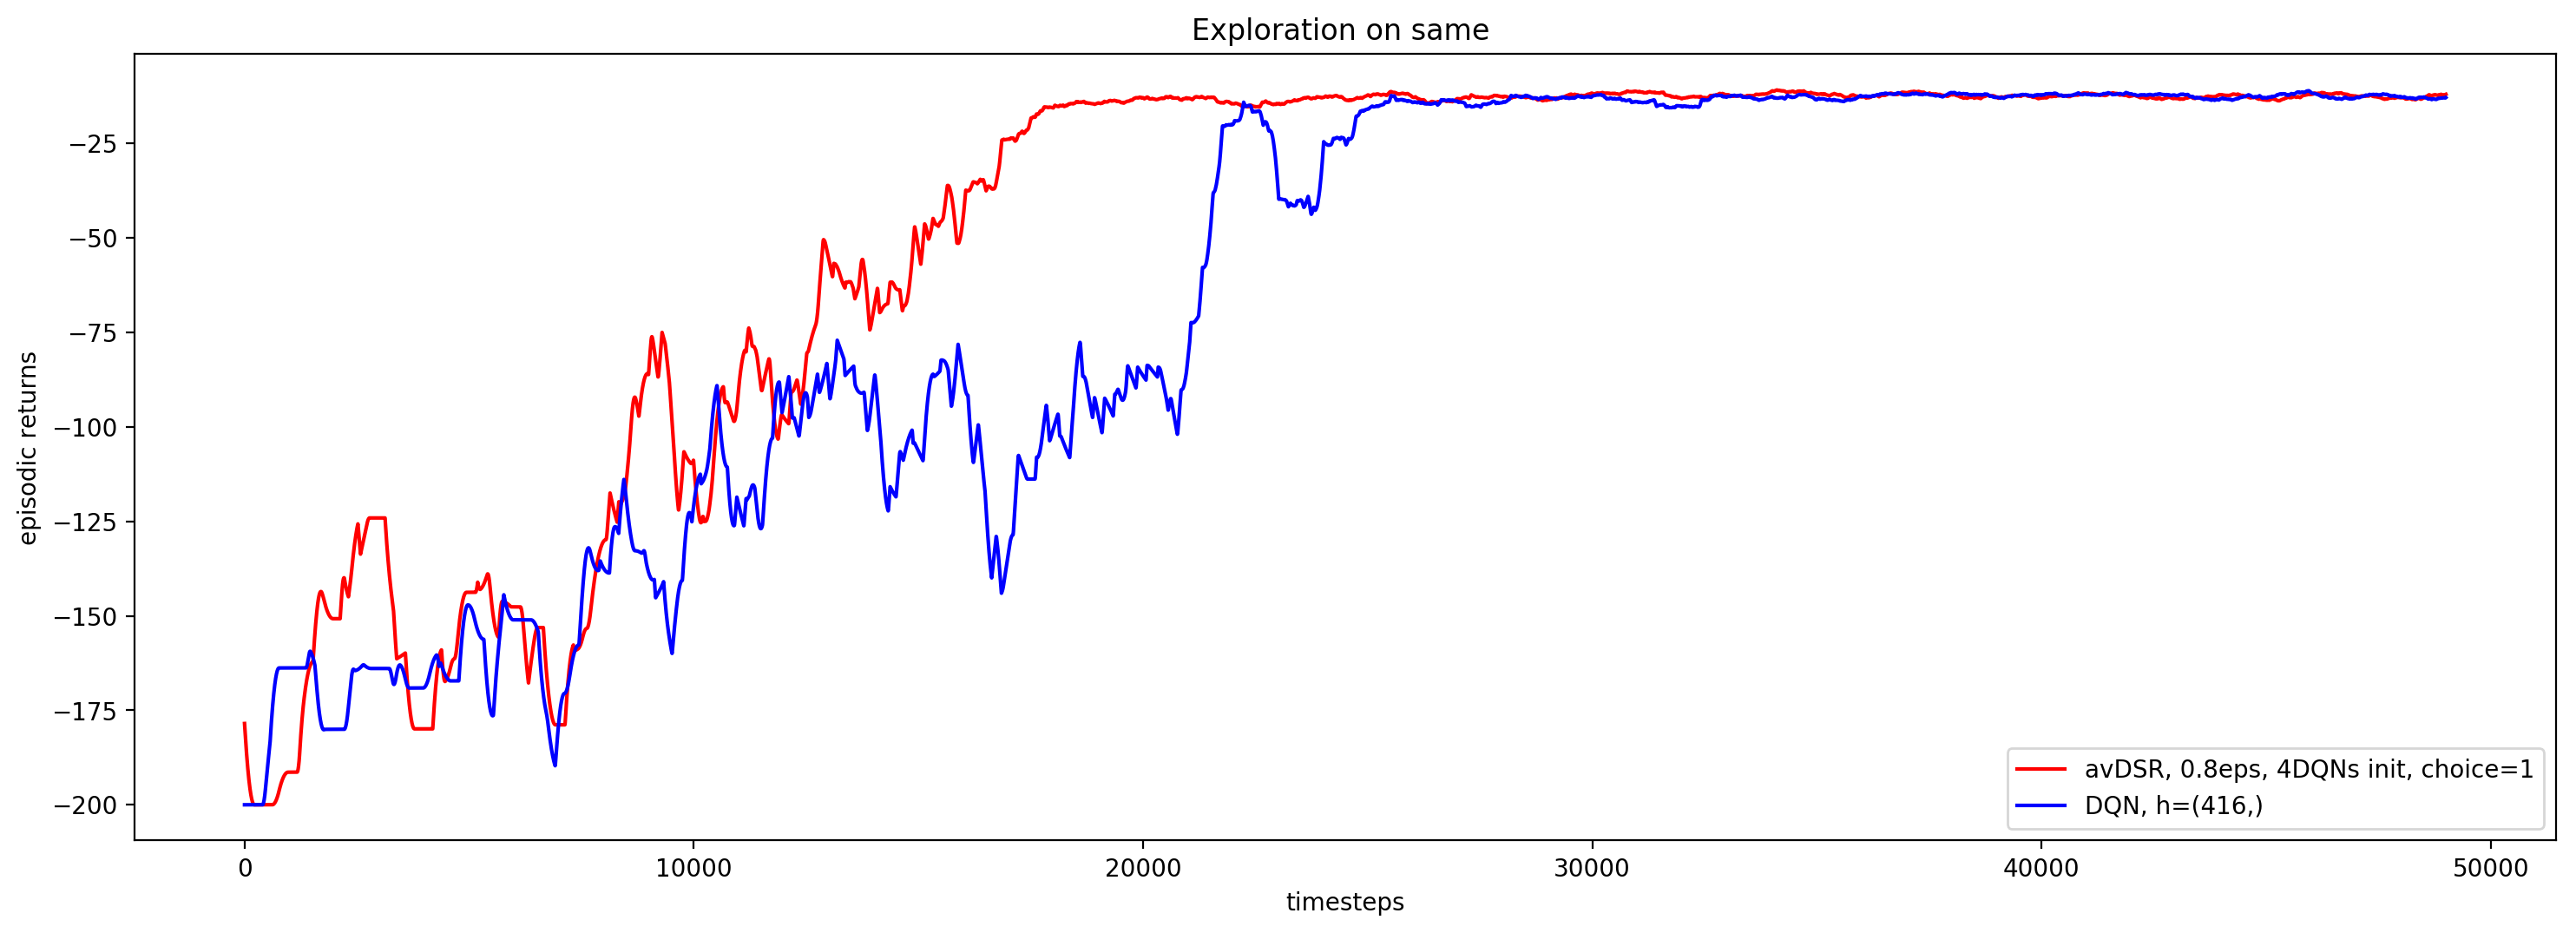

In [19]:
rewards_dict = {\
#                 'avDSR, 0.8eps, 1choice (4 DQNs init)':r_dsr_init_dqns_4rooms_c1,
#                 'avDSR, 0.8eps, 0choice (4 DQNs init)':r_dsr_init_dqns_4rooms_c0,
#                 'OOD: avDSR, 0.8eps, 0choice (3DQNs init)': r_dsr_init_ood_c0,
                'avDSR, 0.8eps, 4DQNs init, choice=1':r_dsr_init_rand,
                'DQN, h=(416,)': r_dqn_base}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='Exploration on same ')

(104, 2)


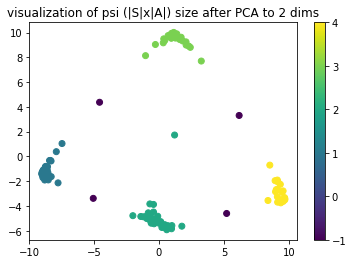

In [106]:
from sklearn.decomposition import PCA

def dimenRed(vis_agent):
    """
    Function to reduce the dimensionality of the psi(s,a) representations learnt,
    and visualizing them.
    """
    state_space = np.identity(104)
    c = np.ones(104)*4
    room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
    room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
    room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
    connect = [25, 51, 62, 88]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -1, -1, -1]
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    psi = psi.view(104,-1).detach().numpy()
    pca = PCA(n_components=2)
    k = pca.fit_transform(psi)
    print(k.shape)
    plt.scatter(k[:,0],k[:,1],c=c)
    plt.colorbar()
    plt.title('visualization of psi (|S|x|A|) size after PCA to 2 dims')
    
    
def dimenRed2(vis_agent, act_agent):
    """
    Function to reduce the dimensionality of the psi* representations learnt,
    and visualizing them.
    NOTE: psi*, where are the optimal actions picked from matters. act_agent 
    is used here.
    """
    state_space = np.identity(104)
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    
    if('DSR' in str(type(act_agent))):
        _, _, q = act_agent.network(tensor(state_space))
    else:
        q = act_agent.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
    
    pass

dimenRed(avdsr)